In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../')
%run setup.py install
os.chdir(owd)

In [2]:
import numpy as np
import pyross
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
## population and age classes
M=16  ## number of age classes

my_data = np.genfromtxt('data/age_structures/India-2019.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

Ni=aM+aF;   Ni=Ni[0:M];  N=np.sum(Ni)

In [4]:
# contact matrices
my_data = pd.read_excel('data/contact_matrices_152_countries/MUestimates_home_1.xlsx', sheet_name='India',index_col=None)
CH = np.array(my_data)

my_data = pd.read_excel('data/contact_matrices_152_countries/MUestimates_work_1.xlsx', sheet_name='India',index_col=None)
CW = np.array(my_data)

my_data = pd.read_excel('data/contact_matrices_152_countries/MUestimates_school_1.xlsx', sheet_name='India',index_col=None)
CS = np.array(my_data)

my_data = pd.read_excel('data/contact_matrices_152_countries/MUestimates_other_locations_1.xlsx', sheet_name='India',index_col=None)
CO = np.array(my_data)

my_data = pd.read_excel('data/contact_matrices_152_countries/MUestimates_all_locations_1.xlsx', sheet_name='India',index_col=None)
CA = np.array(my_data)

In [5]:
# epidemic parameters
alpha = 0.              # asymptomatic fraction
beta  = 0.0155          # contact rate parameter
gamma = 1./7            # recovery rate 
fsa   = 1               # suppresion of contact by symptomatics

Tf=70; 
CTS = np.zeros((2*Tf, M*M))

for i in range(2*Tf):
    if i<21:
        CTS[i, :] = (CH+CW+CS+CO).reshape(M*M)
    elif 21<=i<70:
        CTS[i, :] = (CH).reshape(M*M)
    if 70<=i<98:
        CTS[i, :] = 0#(CH+CW+CS+CO).reshape(M*M)

# initial conditions    
Is_0 = np.zeros((M));  Is_0[4:11]=4;  Is_0[1:4]=1
Ia_0 = np.zeros((M))
R_0  = np.zeros((M))
S_0  = Ni - (Ia_0 + Is_0 + R_0)

# start simulation
model = pyross.models.SIR(S_0, Ia_0, Is_0, alpha, beta, gamma, fsa, M, Ni, Tf)
Nf=8000; filename='this.mat'
model.simulate(CTS, Nf, filename)




# initial conditions    
Is_0 = np.zeros((M));  Is_0[4:11]=4;  Is_0[1:4]=1
Ia_0 = np.zeros((M))
R_0  = np.zeros((M))
S_0  = Ni - (Ia_0 + Is_0 + R_0)

def r0Comp(C):# matrix for linearised dynamics
    L0 = np.zeros((M, M))
    L  = np.zeros((2*M, 2*M))

    for i in range(M):
        for j in range(M):
            L0[i,j]=C[i,j]*Ni[i]/Ni[j]
    L[0:M, 0:M]     =    (alpha*beta/gamma)*L0
    L[0:M, M:2*M]   = fsa*(alpha*beta/gamma)*L0
    L[M:2*M, 0:M]   =    ((1-alpha)*beta/gamma)*L0
    L[M:2*M, M:2*M] = fsa*((1-alpha)*beta/gamma)*L0

    return np.real(np.max(np.linalg.eigvals(L-np.identity(2*M))))
r0=r0Comp(CH+CW+CS+CO)
r1=r0Comp(CH)



# start simulation
model = pyross.models.SIR(S_0, Ia_0, Is_0, alpha, beta, gamma, fsa, M, Ni, Tf)
Nf=8000; filename='this.mat'
model.simulate(CTS, Nf, filename)

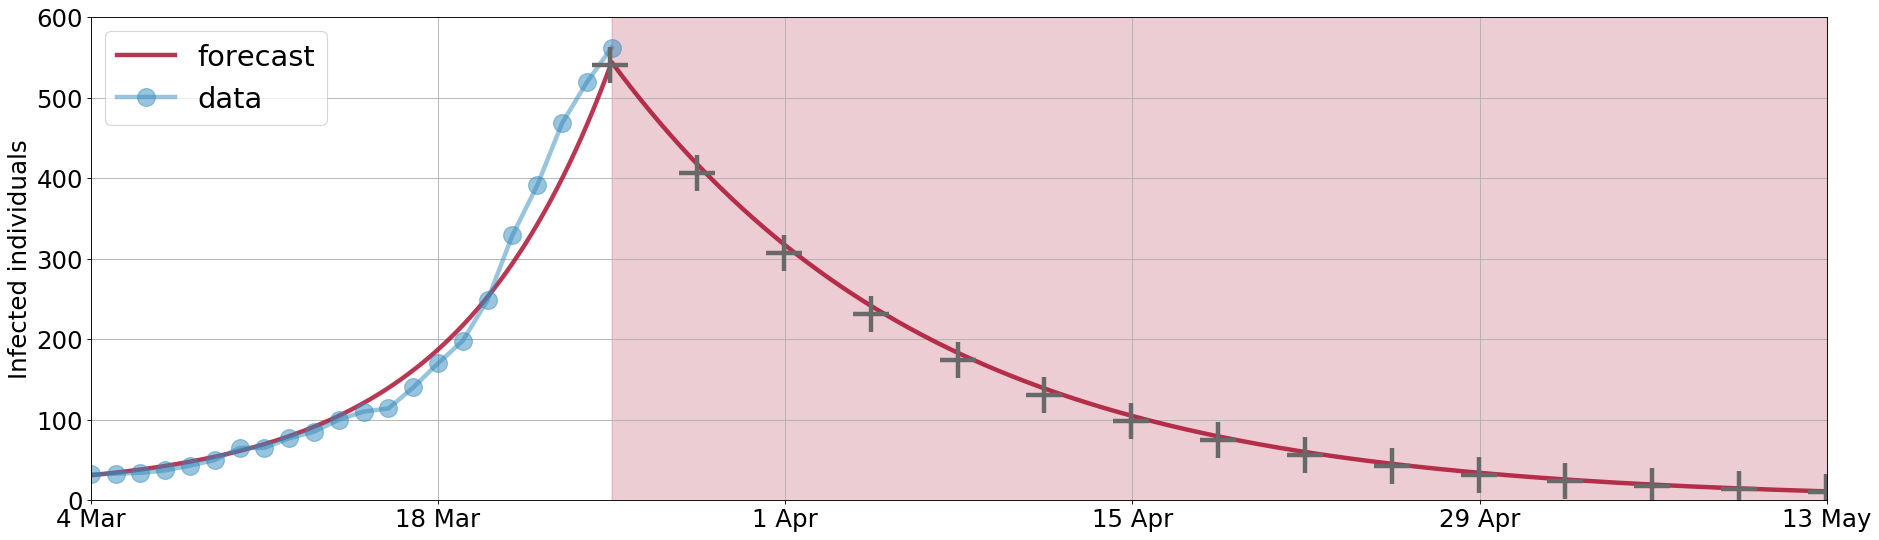

In [6]:
from scipy.io import loadmat
data=loadmat(filename)
IC  = np.zeros((Nf))
for i in range(M):
        IC += data['X'][:,2*M+i] 
t = data['t'][0]
fig = plt.figure(num=None, figsize=(28, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

plt.plot(t, IC, '-', lw=4, color='#A60628', label='forecast', alpha=0.8)
plt.xticks(np.arange(0, 200, 14),('4 Mar','18 Mar','1 Apr','15 Apr','29 Apr','13 May','27 May','10Jun'));

t1=int(Nf/(71/7))
plt.fill_between(t[3*t1+35:], 0, 600, color="#A60628", alpha=0.2)
#plt.fill_between(t[10*t1+10:14*t1+70], 0, 600, color="#A60628", alpha=0.2)

my_data = np.genfromtxt('data/covid-cases/india.txt', delimiter='', skip_header=6)
day, cases = my_data[:,0], my_data[:,2]

plt.plot(cases, 'o-', lw=4, color='#348ABD', ms=16, label='data', alpha=0.5)
plt.legend(fontsize=26, loc='upper left'); plt.grid() 

plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Infected individuals'); plt.ylim(0, 600); plt.xlim(0, 98);
#plt.savefig('/Users/rsingh/Desktop/4d.png', format='png', dpi=200)
#IC[-1]

tLC = t[3*t1+30:]; nD=400
plt.plot(tLC[::nD], IC[3*t1+30]*np.exp(gamma*r1*(tLC-tLC[0]))[::nD], '+', color='dimgrey', ms=32, mew=4)
plt.ylabel('Infected individuals'); plt.ylim(0, 600); plt.xlim(0, 70);
#plt.savefig('/Users/rsingh/Desktop/4a.png', format='png', dpi=200)

In [7]:
print('The time scale for the two rising and decaying exponential to match is', np.abs(r0*21/r1))

The time scale for the two rising and decaying exponential to match is 41.03461525121417
